# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving informaton out of natural language (could be seqeuences text or speech).

Another common term for NLP problems is sequence to sequence problems (seq2seq).

> 📖 **Resource:** See all course materials, resources and extra-curriculum for this notebook on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/

In [1]:
import tf_keras as keras

## Check for GPU

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ebabdcda-6b40-6f3c-e4b8-49eb287f6d84)


## Get helper functions

In [3]:
!wget https://raw.githubusercontent.com/sercanxs/Notes/refs/heads/master/Notes/TensorFlow/Extra/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2025-02-28 13:50:39--  https://raw.githubusercontent.com/sercanxs/Notes/refs/heads/master/Notes/TensorFlow/Extra/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10268 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.03K  --.-KB/s    in 0s      

2025-02-28 13:50:39 (76.0 MB/s) - ‘helper_functions.py’ saved [10268/10268]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as diaster or not diaster).

See the original source here: https://www.kaggle.com/c/nlp-getting-started

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2025-02-28 13:50:39--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.01s   

2025-02-28 13:50:40 (59.4 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python: https://realpython.com/read-write-files-python/

But I prefer to get visual straight away.

So another way to do this is to use pandas...

In [5]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of each class?
train_df.target.value_counts()

,count
target,
0,4342
1,3271


In [9]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [10]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real diaster)" if target > 0 else "(not real diaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real diaster)
Text:
@CodeMeW Were you opening regular or master packs? RT: soÛ_ sunkÛ_1 mil credits into light sideÛ_ didn't pullÛ_oneÛ_you sure about those odds?

---

Target: 1 (real diaster)
Text:
Ton of smoke coming out of one of the new apartment buildings at 160 Ross in Auburn. Several fire trucks on scene. http://t.co/AHVYmSQHqC

---

Target: 1 (real diaster)
Text:
Investigators have said a Virgin Galactic spaceship crash was caused by structural failure after the co-pilot ... http://t.co/PnhPLJHo8E

---

Target: 0 (not real diaster)
Text:
IÛªve seen lots ask about this MT @JMCwrites #Pitchwars I asked for magic realism but not fantasy. What's the diff? http://t.co/64xR9LtNOH

---

Target: 1 (real diaster)
Text:
@accionempresa ChinaÛªs stock market crash this summer has sparked interest from bargain hunt... http://t.co/s0Eyq1wEHE @gerenciatodos å¨

---



### Split data into training and validation sets

We want to be able to see how our model is performing on unseen data whilst it trains.

And because the testing dataset doesn't have labels, we'll have to create a validation dataset to evaluate on (the model won't see the validation dataset during training so we can use its samples and labels to evaluate our model's performance).

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # use 10% of training data for validation split
                                                                            random_state=42)

In [13]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenziation - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [15]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [17]:
import tensorflow as tf
from tf_keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=10000, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be?
                                    pad_to_max_tokens=True)

In [18]:
len(train_sentences[0].split())

7

In [19]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [20]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [21]:
# Fit the text vectorizer instance to the training data using the adapt() method
text_vectorizer.adapt(train_sentences)

In [22]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [23]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
@okgabby_ damn suh. don't let that ruin your year bruh. this our year. better start carpooling like we did back in the day        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1,  821, 4507,   63,  181,   16,  415,   33,  183, 1888,   19,
         103,  183,  441,  667]])>

In [24]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # the most common words in the vocab
bottom_5_words = words_in_vocab[-5:] # the least common words in the vocab
print(f"Most common words in vocab: {top_5_words}")
print(f"Least common words in vocab: {bottom_5_words}")

Most common words in vocab: ['', '[UNK]', 'the', 'a', 'in']
Least common words in vocab: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [25]:
# how long is our vocab?
len(words_in_vocab)

10000

## Creating an Embedding using an Embedding Layer

In [26]:
max_length,

(15,)

In [27]:
from tf_keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set the input shape
                             output_dim=128, # set the size of the embedding vector
                             embeddings_initializer="uniform", # default, initialize embedding vectors randomly
                             input_length=max_length # how long is each input
                             )

embedding

In [28]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
        \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation, aka tokenization first)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
@kessily @mishacollins So we should send it all 2 him then? Drown him in it? I like the way u think! #AllTheKidneyBeansAndSorbet4Misha #YES        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 2.2450391e-02, -4.2856980e-02, -2.0284140e-02, ...,
         -1.7089713e-02,  4.7381762e-02, -3.0236006e-02],
        [-4.5660615e-02,  1.8356573e-02,  4.4943225e-02, ...,
         -1.2472868e-03, -2.6267087e-02,  3.6156606e-02],
        [ 4.2553637e-02,  4.7153462e-02, -8.1419945e-05, ...,
          4.7558021e-02, -8.8529214e-03,  2.6776884e-02],
        ...,
        [-9.6629150e-03, -4.4627413e-03,  4.4780973e-02, ...,
         -3.7834086e-02, -2.0729411e-02,  1.7181206e-02],
        [-4.5349646e-02, -9.6480958e-03,  4.1857813e-02, ...,
         -4.1107975e-02, -2.8327549e-02,  6.3669309e-03],
        [ 2.3169670e-02, -2.0859635e-02, -4.1255616e-02, ...,
          4.3107603e-02, -4.0384032e-02, -4.5432102e-02]]], dtype=float32)>

In [29]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.02245039, -0.04285698, -0.02028414, -0.04072847,  0.04929503,
        0.02097936, -0.0242952 , -0.02686232, -0.04300607,  0.0044185 ,
       -0.00786256,  0.01877233, -0.01762012, -0.02571968,  0.01170758,
       -0.03313631, -0.04294461, -0.04142211,  0.01005485, -0.00106919,
       -0.00219379, -0.04546467, -0.00150973,  0.01627724,  0.00415441,
       -0.00425724, -0.01910758, -0.0301752 , -0.02844051,  0.01108534,
        0.01478792, -0.01573991, -0.04908917,  0.01876738,  0.02674668,
        0.02060027, -0.04096435,  0.00715585, -0.04039126, -0.01247681,
        0.02390179, -0.03547206,  0.04297075, -0.0305663 ,  0.04663113,
       -0.00467349,  0.02527   , -0.04896617, -0.00984491,  0.0349263 ,
       -0.02501783,  0.02742478,  0.00463265,  0.04970768,  0.01661067,
        0.02960291, -0.04718775, -0.00587945,  0.00737208,  0.0086347 ,
       -0.03435481, -0.01925679, -0.04386363, -0.01860581, -0.04466433,
        0.018627

## Modelling a text dataset (setting up our modelling experiments)

Now we've got our data in numerical format, let's start building and comparing different models.

* Model 0: Naive Bayes (baseline) - got this from here: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional LSTM
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Word Embedding (feature extractor)
* Model 7: Same as model 6 but using 10% of data

For each of these models, we're going to be following the TensorFlow steps in modelling:
* Construct the model
* Train the model
* Make predictions with the model
* Track prediction evaluation metrics for later comparison

In [30]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
                    ("clf", MultinomialNB()) # model the text converted to numbers
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

CPU times: user 186 ms, sys: 11.2 ms, total: 197 ms
Wall time: 213 ms


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [31]:
# Let's evalaute our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [32]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

Let's make a function to evaluate our modelling experiment predictions using:
* Accuracy
* Precision
* Recall
* F1-score

In [33]:
# Function to evalaute: accuracy, precision, recall, F1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  ----
  y_true = true labels in the form of a 1D array
  y_pred = predicted label in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall and f1-score between y_true and y_pred.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100 # get accuracy score in percentage value
  # Calculate model precision, recall and f1 score using "weighted" avergage
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  # Create a dictionary of model results
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [34]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model (feed-forward neural network)

In [35]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [36]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [37]:
# Build model with the Functional API
from tf_keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [38]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                               experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20250228-135421
Epoch 1/5
215/215 [==============================] - 10s 39ms/step - loss: 0.6087 - accuracy: 0.7003 - val_loss: 0.5380 - val_accuracy: 0.7493
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4414 - accuracy: 0.8187 - val_loss: 0.4686 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3469 - accuracy: 0.8606 - val_loss: 0.4592 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2844 - accuracy: 0.8899 - val_loss: 0.4767 - val_accuracy: 0.7966
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2381 - accuracy: 0.9117 - val_loss: 0.4779 - val_accuracy: 0.7861


In [39]:
# Evaluate model 1
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4779 - accuracy: 0.7861


[0.47794920206069946, 0.7860892415046692]

In [40]:
# Make predictions with model_1
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.3358603 ],
       [0.75224155],
       [0.9978452 ],
       [0.10346445],
       [0.11275542],
       [0.9475866 ],
       [0.9212488 ],
       [0.9916824 ],
       [0.96564466],
       [0.24260451]], dtype=float32)

In [41]:
# Convert model_1 pred probs from probabilities to prediction labels
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [42]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [43]:
# Evaluate model_1 with our evaluation function
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7916211438846743,
 'recall': 0.7860892388451444,
 'f1': 0.782856754224963}

In [44]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [45]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

### Visualizing learned embeddings

To further understand word embeddings, let's visualize them, to do so, we'll get the weights matrix (embedding matrix) from our embedding layer and visualize it using the Embedding project tool, see the TensorFlow guide for more: https://www.tensorflow.org/tutorials/text/word_embeddings

In [46]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [47]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [48]:
# Get the weight matrix of embedding layer
# (the weights are the numerical patterns between the text in the training dataset that the model has learned)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [49]:
import io

# Code to save trained embeddings to file - we got this from here: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [50]:
# Let's download the saved embeddings locally
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Our visual word embeddings might not look like much to us, but they help our model understand the relationships between words.

For more on a popular type of word embedding and more visual explanations check out the illustrated word2vec: https://jalammar.github.io/illustrated-word2vec/

## Model 2: LSTM

* LSTM = long short-term memory

For more on RNN's/resources to learn, see here: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb

We're going to focus on writing the code.

In [51]:
# Create LSTM model
from tf_keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(f"After embedding: {x.shape}")
# x = layers.LSTM(64, activation="tanh", return_sequences=True)(x) # use return_sequences=True if you want to stack recurrent layers
# print(f"After LSTM cell with return_sequences=True: {x.shape}")
x = layers.LSTM(64, activation="tanh")(x)
print(f"After LSTM cell: {x.shape}")
# x = layers.Dense(64, activation="relu")(x) # optional dense layer to have on top of LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = keras.Model(inputs, outputs, name="model_2_LSTM")


After embedding: (None, 15, 128)
After LSTM cell: (None, 64)


In [52]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
history_2 = model_2.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                               experiment_name="model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20250228-135440
Epoch 1/5
215/215 [==============================] - 11s 35ms/step - loss: 0.2294 - accuracy: 0.9167 - val_loss: 0.5474 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1565 - accuracy: 0.9422 - val_loss: 0.6993 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1268 - accuracy: 0.9530 - val_loss: 0.6713 - val_accuracy: 0.7835
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1021 - accuracy: 0.9603 - val_loss: 0.6812 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0831 - accuracy: 0.9685 - val_loss: 1.0457 - val_accuracy: 0.7795


In [53]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[2.7686383e-03],
        [7.1609449e-01],
        [9.9961698e-01],
        [6.7799380e-03],
        [3.1588983e-04],
        [9.9887186e-01],
        [7.7746803e-01],
        [9.9972969e-01],
        [9.9955434e-01],
        [4.3359911e-01]], dtype=float32))

In [54]:
# Round out pred probs and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [55]:
# Calculate our LSTM model's results
model_2_preds = tf.squeeze(tf.round(model_2_preds))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [56]:
# Calculate our model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.95275590551181,
 'precision': 0.7829461349391948,
 'recall': 0.7795275590551181,
 'f1': 0.7768651797484591}

## Model 3: GRU

GRU = Gated recurrent unit (one of the most popular and useful recurrent layer types)

📖 **Resource:** If you want to see the formula for Tanh, a great extension would be to replicate the function in pure TensorFlow, see here: https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh

In [57]:
# Build an RNN using the GRU cell
from tf_keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GRU(64, activation="tanh", return_sequences=True)(x) # return_sequences=True is required for stacking recurrent cells
# print(x.shape)
x = layers.GRU(64, activation="tanh")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = keras.Model(inputs, outputs, name="model_3_GRU")

In [58]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [59]:
# Compile model_3 (GRU)
model_3.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20250228-135504
Epoch 1/5
215/215 [==============================] - 11s 35ms/step - loss: 0.1643 - accuracy: 0.9339 - val_loss: 0.7371 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0863 - accuracy: 0.9669 - val_loss: 0.8070 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0704 - accuracy: 0.9739 - val_loss: 0.9354 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0608 - accuracy: 0.9753 - val_loss: 1.2051 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0490 - accuracy: 0.9783 - val_loss: 1.0704 - val_accuracy: 0.7743


In [60]:
# Make predictions with the trained model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10], model_3_pred_probs.shape

24/24 [==============================] - 0s 3ms/step


(array([[2.9340282e-03],
        [8.1896198e-01],
        [9.9947947e-01],
        [1.4124553e-01],
        [1.8262083e-04],
        [9.9937505e-01],
        [8.3805311e-01],
        [9.9988914e-01],
        [9.9974269e-01],
        [8.2562160e-01]], dtype=float32),
 (762, 1))

In [61]:
# Convert model 3 pred probs into labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [62]:
# Calculate results for model 3
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.42782152230971,
 'precision': 0.7749000605693519,
 'recall': 0.7742782152230971,
 'f1': 0.7728247037302155}

## Model 4: Bidirectional RNN model

In [63]:
# Build a bidirectional RNN in TensorFlow
from tf_keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # return_sequences=True required for stacking RNN layers
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = keras.Model(inputs, outputs, name="model_4_bidirectional")

In [64]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [65]:
# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
history_model_4 = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20250228-135524
Epoch 1/5
215/215 [==============================] - 26s 77ms/step - loss: 0.1097 - accuracy: 0.9673 - val_loss: 0.8785 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0538 - accuracy: 0.9784 - val_loss: 1.0986 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0453 - accuracy: 0.9783 - val_loss: 1.3382 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0447 - accuracy: 0.9793 - val_loss: 1.1766 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0399 - accuracy: 0.9818 - val_loss: 1.4150 - val_accuracy: 0.7756


In [66]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10], model_4_pred_probs.shape

24/24 [==============================] - 1s 3ms/step


(array([[2.4509253e-03],
        [7.4735481e-01],
        [9.9996841e-01],
        [2.0442317e-01],
        [2.9686471e-05],
        [9.9966824e-01],
        [9.2740077e-01],
        [9.9998987e-01],
        [9.9997878e-01],
        [9.9855548e-01]], dtype=float32),
 (762, 1))

In [67]:
# Convert pred probs to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [68]:
# Calculate model 4 results
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 77.55905511811024,
 'precision': 0.7780461459912817,
 'recall': 0.7755905511811023,
 'f1': 0.7732287214395843}

## Model 5: Conv1D

We've seen before how convolutional neural networks can be used for images but they can also be used for text.

Previously we've used the layer Conv2D (which is great for images with (height, width)).

But if we want to use convolutional layers for sequences (e.g. text) we need to use Conv1D: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D

For more of a deep dive into what goes on behind the scenes in a CNN for text (or sequences) see the paper: https://arxiv.org/abs/1809.08037

In [69]:
# Let's do a little test to see what things look like through the eyes of a Conv1D layer
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d_layer = layers.Conv1D(filters=32,
                              kernel_size=5, # setting this to 5 means it'll look at 5 words at a time, 3 would mean 3 words at a time
                              activation="relu")
conv_1d_output = conv_1d_layer(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
print(f"Embedding output shape: {embedding_test.shape}")
print(f"Conv1D output shape: {conv_1d_output.shape}")
print(f"Max pool output shape: {max_pool_output.shape}")

Embedding output shape: (1, 15, 128)
Conv1D output shape: (1, 11, 32)
Max pool output shape: (1, 32)


In [70]:
# Let's see the outputs of each layer
print(f"Embedding output: {embedding_test}")
print(f"Conv1D output: {conv_1d_output}")
print(f"Max pool output: {max_pool_output}")

Embedding output: [[[ 0.04461039  0.02027658 -0.04752525 ...  0.01791649  0.0054278
   -0.02562307]
  [ 0.01612671 -0.00712238  0.03023337 ... -0.0087319   0.02464416
   -0.01439631]
  [ 0.01074031  0.05681172 -0.04312659 ... -0.0423739  -0.02306329
    0.00302674]
  ...
  [-0.00127667 -0.00696399 -0.05185926 ... -0.02498288 -0.00701804
   -0.00587248]
  [-0.00127667 -0.00696399 -0.05185926 ... -0.02498288 -0.00701804
   -0.00587248]
  [-0.00127667 -0.00696399 -0.05185926 ... -0.02498288 -0.00701804
   -0.00587248]]]
Conv1D output: [[[1.85325649e-02 3.01706623e-02 3.59676704e-02 0.00000000e+00
   0.00000000e+00 3.64846848e-02 0.00000000e+00 0.00000000e+00
   2.54804157e-02 3.53855975e-02 2.43533552e-02 5.75315878e-02
   0.00000000e+00 5.91534972e-02 5.69058582e-02 3.21712084e-02
   2.68112659e-03 7.47540891e-02 3.77927609e-02 3.58049162e-02
   7.51780048e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
   4.97065438e-03 0.00000000e+00 3.52384821e-02 4.69780564e-02
   0.00000000e+00 2.9

In [71]:
# Create 1-dimensional CNN to model sequences
from tf_keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
model_5 = keras.Model(inputs, outputs, name="model_5_conv1d")

model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 output_layer (Dense)        (None, 1)              

In [72]:
BATCH_SIZE = 32

In [73]:
# Compile model
model_5.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_model_5 = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              batch_size=BATCH_SIZE,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_5_conv1d")])

Saving TensorBoard log files to: model_logs/model_5_conv1d/20250228-135603
Epoch 1/5
215/215 [==============================] - 9s 36ms/step - loss: 0.1317 - accuracy: 0.9607 - val_loss: 0.8512 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0745 - accuracy: 0.9711 - val_loss: 1.0063 - val_accuracy: 0.7638
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0602 - accuracy: 0.9771 - val_loss: 1.1188 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0535 - accuracy: 0.9780 - val_loss: 1.1649 - val_accuracy: 0.7546
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0512 - accuracy: 0.9790 - val_loss: 1.2119 - val_accuracy: 0.7690


In [74]:
# Make predictions with our 1D CNN
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:5], model_5_pred_probs.shape

24/24 [==============================] - 0s 3ms/step


(array([[1.7015937e-01],
        [8.6971515e-01],
        [9.9977750e-01],
        [8.8827357e-02],
        [3.0693698e-07]], dtype=float32),
 (762, 1))

In [75]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [76]:
# Calculate results for model 5
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 76.9028871391076,
 'precision': 0.7711368167182066,
 'recall': 0.7690288713910761,
 'f1': 0.766666986890819}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

See how the USE was created here: https://arxiv.org/abs/1803.11175

📖 **Resource:** TensorFlow Hub is a great resource for many pretrained models but HuggingFace is also another incredible resource for many pretrained NLP models (using HuggingFace model is beyond the scope of this course but it is definitely something you should be familiar with in the NLP space): https://huggingface.co/models

In [77]:
sample_sentence

"There's a flood in my street!"

In [78]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you can the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [79]:
embed_samples[0].shape

TensorShape([512])

In [80]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [81]:
# Create model using the Sequential API
model_6 = keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [82]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20250228-135654
Epoch 1/5
215/215 [==============================] - 7s 14ms/step - loss: 0.5015 - accuracy: 0.7828 - val_loss: 0.4497 - val_accuracy: 0.8045
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4139 - accuracy: 0.8168 - val_loss: 0.4434 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4014 - accuracy: 0.8206 - val_loss: 0.4357 - val_accuracy: 0.8150
Epoch 4/5
215/215 [==============================] - 4s 16ms/step - loss: 0.3937 - accuracy: 0.8246 - val_loss: 0.4345 - val_accuracy: 0.8097
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3870 - accuracy: 0.8305 - val_loss: 0.4291 - val_accuracy: 0.8136


In [83]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.2004506 ],
       [0.81434596],
       [0.9875252 ],
       [0.20987117],
       [0.7346146 ],
       [0.7805055 ],
       [0.98266184],
       [0.98004514],
       [0.95515156],
       [0.09371658]], dtype=float32)

In [84]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [85]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.36482939632546,
 'precision': 0.813881331804605,
 'recall': 0.8136482939632546,
 'f1': 0.8129452568428948}

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

In [86]:
# ## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% data)
# ## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# # train_10_percent.head(), len(train_10_percent)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

> 🔑 **Note:** Be *very* careful when creating training/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100% of data) trust your gut and go back through to find where the error may lie.

In [87]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [88]:
# Check the number of each label in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

,count
0,406
1,279


In [89]:
# Check the number of targets in our subset of data
train_df_shuffled["target"].value_counts()

,count
target,
0,4342
1,3271


To recreate a model the same as a previous model you've created you can use the `keras.models.clone_model()` method, see more here: https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [90]:
# Let's build a model the same as model_6
# model_7 = keras.models.clone_model(model_6)
model_7 = keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_7_USE")

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [91]:
# Fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20250228-135713
Epoch 1/5
22/22 [==============================] - 3s 65ms/step - loss: 0.6757 - accuracy: 0.6307 - val_loss: 0.6532 - val_accuracy: 0.7480
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.6119 - accuracy: 0.7912 - val_loss: 0.5979 - val_accuracy: 0.7717
Epoch 3/5
22/22 [==============================] - 0s 23ms/step - loss: 0.5389 - accuracy: 0.8044 - val_loss: 0.5436 - val_accuracy: 0.7690
Epoch 4/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4764 - accuracy: 0.8204 - val_loss: 0.5088 - val_accuracy: 0.7677
Epoch 5/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4326 - accuracy: 0.8263 - val_loss: 0.4908 - val_accuracy: 0.7743


In [92]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 15ms/step


array([[0.2261908 ],
       [0.5559238 ],
       [0.91726226],
       [0.37081212],
       [0.5347191 ],
       [0.6991843 ],
       [0.88110584],
       [0.8197716 ],
       [0.8323903 ],
       [0.16345964]], dtype=float32)

In [93]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [94]:
# Evalaute model 7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 77.42782152230971,
 'precision': 0.7752857985262857,
 'recall': 0.7742782152230971,
 'f1': 0.7725974162749719}

## Comparing the peformance of each of our models

In [95]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.608924,0.791621,0.786089,0.782857
2_lstm,77.952756,0.782946,0.779528,0.776865
3_gru,77.427822,0.774900,0.774278,0.772825
4_bidirectional,77.559055,0.778046,0.775591,0.773229
5_conv1d,76.902887,0.771137,0.769029,0.766667
6_tf_hub_use_encoder,81.364829,0.813881,0.813648,0.812945
7_tf_hub_use_encoder_10_percent,77.427822,0.775286,0.774278,0.772597


In [96]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
# all_model_results

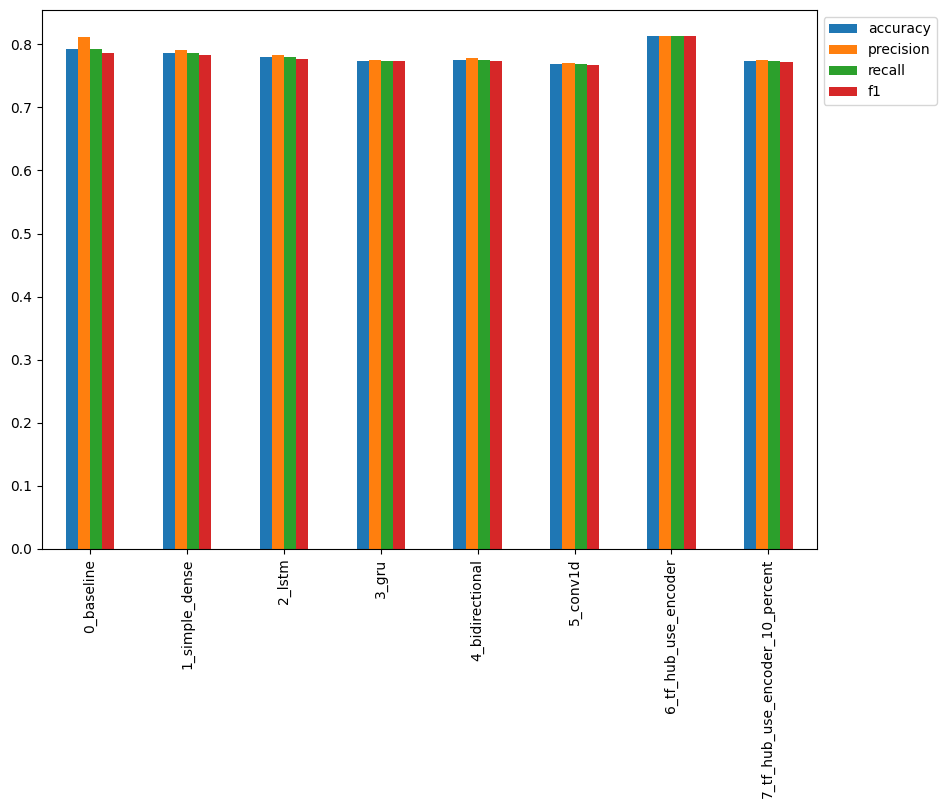

In [97]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

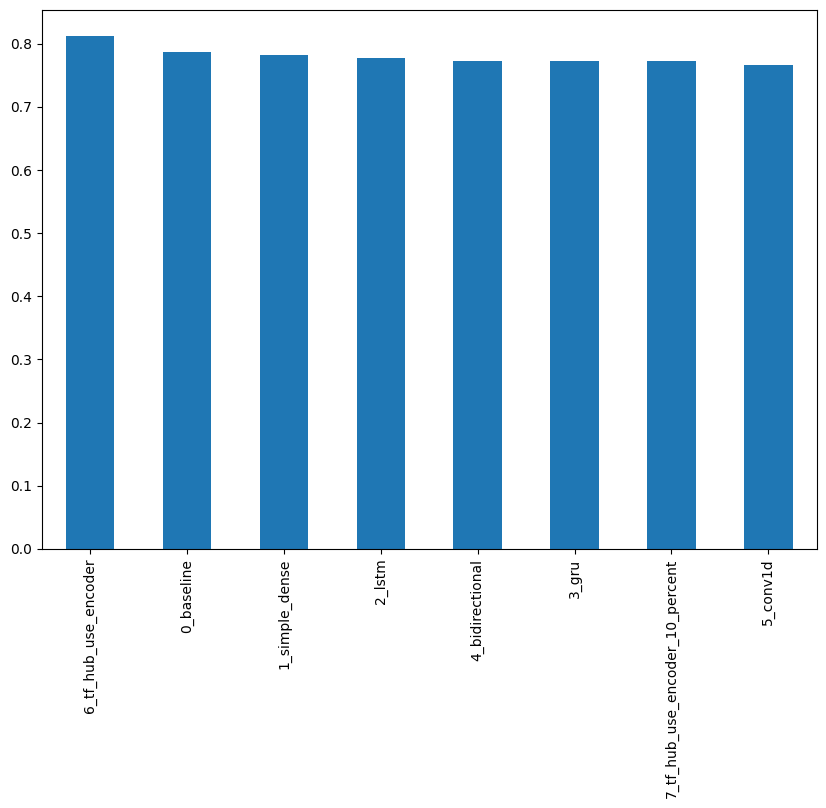

In [98]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Uploading our model training logs to TesnorBoard.dev
We can further inspect our model's performance using TensorBoard.dev: https://tensorboard.dev/

In [99]:
# # View TensorBoard logs of transfer learning modelling experiments (plus all of our other models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs/ \
#   --name "NLP Modelling Experiments ZTM TF Course Video" \
#   --description "Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset" \
#   --one_shot # exit the uploader once uploading is finished

Now I've ran the cell above, my modelling experiments are visable on TensorBoard.dev: https://tensorboard.dev/experiment/Eacboed3RbKPWIGcXe1Z6g/

> 📖 **Resource:** TensorBoard is great for quickly tracking experiments but for larger scale experiments and a whole bunch more tracking options, check out Weights & Biases: https://wandb.ai/site

In [100]:
# # See the previous TensorBoard Dev experiments you've run...
# !tensorboard dev list

In [101]:
# If you need to delete an experiment from TensorBoard, you can run the following:
# !tensorboard dev delete --experiment_id Eacboed3RbKPWIGcXe1Z6gB

## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SavedModel` format (this is the default when using TensorFlow)

In [102]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [103]:
# Load model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [104]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4291 - accuracy: 0.8136


[0.42908963561058044, 0.8136482834815979]

Now let's save to the `SavedModel` format... (see more on this here: https://www.tensorflow.org/tutorials/keras/save_and_load)

In [105]:
# Save TF Hub Sentence Ecnoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [106]:
# Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = keras.models.load_model("model_6_SavedModel_format")

In [107]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 19ms/step - loss: 0.4291 - accuracy: 0.8136


[0.42908960580825806, 0.8136482834815979]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those will predicition probabilities closest to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (really close to 1) and vice versa.

In [108]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2025-02-28 13:58:09--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  36.3MB/s    in 18s     

2025-02-28 13:58:27 (50.7 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.i

In [109]:
# Import previously trained model from Google Storage
model_6_pretrained = keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 23ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [110]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10] # these should be in label format

24/24 [==============================] - 2s 29ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [111]:
# Create DataFrame with validation sentences, validation labels and best performing model prediction labels + probabilities
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [112]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10] # these are false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [113]:
most_wrong.tail() # these are false negatives

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


Let's remind ourselves of the target labels...
* `0` = not diaster
* `1` = diaster

In [114]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769821524620056
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523001074790955
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272132277488708
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

In [115]:
# Check the false negatives (model predicted 0 when should've been 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0.0, Prob: 0.06730347871780396
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.05507584288716316
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.05460337549448013
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.054597001522779465
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.049637261778116226
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 0

## Making predictions on the test dataset

In [116]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-----\n")

1/1 [==============================] - 0s 74ms/step
Pred: 1, Prob: 0.9071048498153687
Text:
Here we are 70 years after the nuclear obliteration of Hiroshima and Nagasaki and IÛªm wondering iÛ_ http://t.co/fvkekft4Rs

-----

1/1 [==============================] - 0s 79ms/step
Pred: 1, Prob: 0.9511893391609192
Text:
#ISIS claims credit for suicide bombing 'with 6 tons of explosives' at the central command of #Syria(n) T4 airbase http://t.co/QOaU2QLJ3B

-----

1/1 [==============================] - 0s 76ms/step
Pred: 0, Prob: 0.14840659499168396
Text:
Curvaceous LADY screams like a mad dog in a Nairobi Club See what happened (VIDEO) - #KOT Join Mature... http://t.co/1szi9X22cr

-----

1/1 [==============================] - 0s 67ms/step
Pred: 1, Prob: 0.7639063000679016
Text:
Newcastle: Schoolgirl attacked in Seaton Delaval park by 'pack of animals' led by a former friend http://t.co/4xbrVNib9T #newcastle

-----

1/1 [==============================] - 0s 120ms/step
Pred: 1, Prob: 0.99637

## Your challenge... predicting on Tweets from the wild

Go to your favourite Twitter account and copy one of their latest Tweets.

Then pass that Tweet through our trained model.

Is that Tweet a disaster or not disaster (according to the model)? Is the model right or wrong?

## The speed/score tradeoff

In [117]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculuate how long predictons took to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [118]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 1s 24ms/step


(0.9009322079998583, 0.0011823257322832786)

In [119]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.04866105300015988, 6.385964960650903e-05)

In [120]:
# Get results for pretrained GS model
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

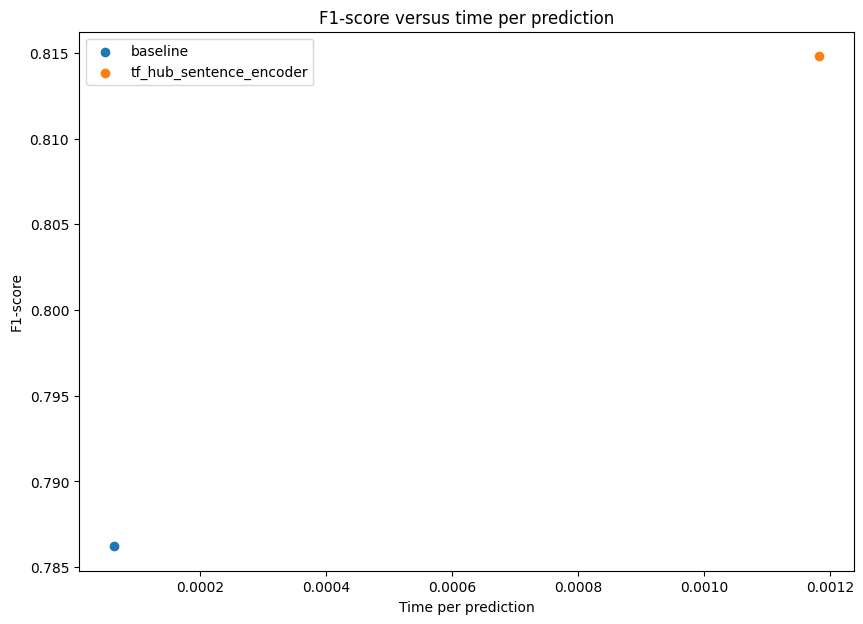

In [121]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score");

> 📖 **Resource:** See all course materials as well as exercises and extra-curriculum for this notebook on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning